In [2]:
#load data
import pandas as pd
import numpy as np
data=pd.read_csv("./datasets/Train_Dataset.csv")
data.head()


,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0


In [3]:
#data cleaning
import pandas as pd
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def preprocess_text(text):
    # Check for NaN values or non-string types
    if not isinstance(text, str):
        return ""  # Return an empty string for non-string types or NaN values
    
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    
    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Apply stemming using Porter Stemmer
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Join the stemmed words back into a string
    preprocessed_text = ' '.join(stemmed_words)
    
    return preprocessed_text

# Apply custom preprocessing to the 'tweet' column
data['cleaned_tweet'] = data['tweet'].apply(preprocess_text)

# Print the preprocessed DataFrame
data.head()


,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question,cleaned_tweet
0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0,thing got colleg caffein addict
1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0,love professor draw big question mark next ans...
2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0,rememb hundr email compani covid start get rea...
3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0,today poppop told forc go colleg okay sure sureee
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0,volphancarol littlewhitti mysticalmanate also ...


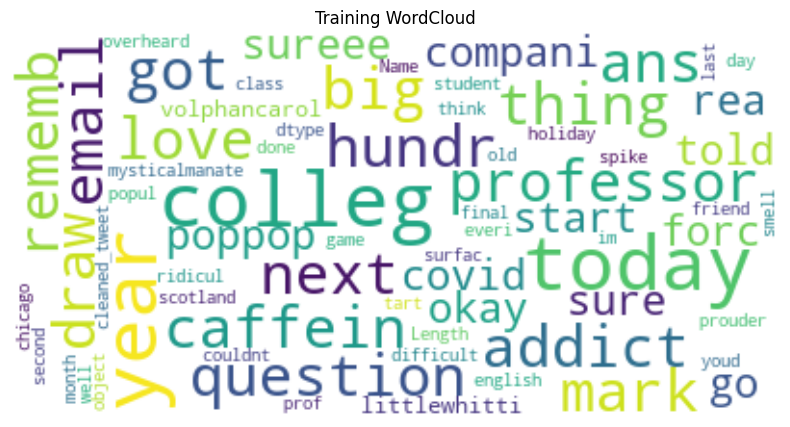

In [4]:
#word cloud representation
import wordcloud as wordcloud
import matplotlib.pyplot as plt

wordcloud = wordcloud.WordCloud(background_color="white", max_words=10000, max_font_size=40).generate(str(data['cleaned_tweet']))
plt.figure(figsize=(10, 5))
plt.title("Training WordCloud")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [7]:
import tensorflow as tf
import numpy as np
from transformers import DistilBertTokenizer, TFDistilBertModel

# Assuming you have a DataFrame called 'data' with columns: 'cleaned_tweet' (input text), 'sarcastic' (teacher model's sarcasm label)

# Tokenize input text
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Assuming your data is in a pandas DataFrame called 'data'
texts = data['cleaned_tweet'].tolist()
teacher_labels = data['sarcastic'].astype(int).tolist()  # Ensure teacher labels are integers

# Tokenize the input
tokenized_inputs = tokenizer(texts, return_tensors='tf', padding=True, truncation=True, max_length=128)
tf_tokenized_inputs = {
    'input_ids': tf.constant(tokenized_inputs['input_ids']),
    'attention_mask': tf.constant(tokenized_inputs['attention_mask'])
}

# Define a custom attention layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_q = self.add_weight(name="W_q", shape=(input_shape[-1], input_shape[-1]), initializer="normal", trainable=True)
        self.W_k = self.add_weight(name="W_k", shape=(input_shape[-1], input_shape[-1]), initializer="normal", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        q = tf.matmul(x, self.W_q)
        k = tf.matmul(x, self.W_k)
        attention_weights = tf.matmul(q, k, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_weights, axis=-1)
        output = tf.matmul(attention_weights, x)
        return output

# Define the DistilledBERT model with custom attention layer
class DistilledBERTWithAttention(tf.keras.Model):
    def __init__(self):
        super(DistilledBERTWithAttention, self).__init__()
        self.distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
        self.attention = AttentionLayer()
        self.hidden_layer = tf.keras.layers.Dense(64, activation='selu')
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
    
    def call(self, inputs, training=False):
        outputs = self.distilbert(inputs, training=training)
        last_hidden_state = outputs.last_hidden_state
        attention_output = self.attention(last_hidden_state)
        pooled_output = tf.reduce_mean(attention_output, axis=1)
        logits = self.output_layer(pooled_output)
        return logits

# Instantiate the model
distilled_bert_model_with_attention = DistilledBERTWithAttention()

# Compile the model
distilled_bert_model_with_attention.compile(optimizer='FTRL', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using teacher's labels
history = distilled_bert_model_with_attention.fit(tf_tokenized_inputs, np.array(teacher_labels), epochs=5, batch_size=36)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/5
97/97 [==============================] - 266s 3s/step - loss: 0.6703 - accuracy: 0.7463
Epoch 2/5
97/97 [==============================] - 252s 3s/step - loss: 0.6594 - accuracy: 0.7500
Epoch 3/5
97/97 [==============================] - 241s 2s/step - loss: 0.6519 - accuracy: 0.7500
Epoch 4/5
97/97 [==============================] - 234s 2s/step - loss: 0.6455 - accuracy: 0.7500
Epoch 5/5
97/97 [==============================] - 233s 2s/step - loss: 0.6398 - accuracy: 0.7500


In [101]:
#model summary
distilled_bert_model_with_attention.summary()

Model: "distilled_bert_with_attention_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_distil_bert_model_5 (TF  multiple                  66362880  
 DistilBertModel)                                                
                                                                 
 attention_layer_3 (Attenti  multiple                  1179648   
 onLayer)                                                        
                                                                 
 dense_6 (Dense)             multiple                  0 (unused)
                                                                 
 dense_7 (Dense)             multiple                  769       
                                                                 
Total params: 67543297 (257.66 MB)
Trainable params: 67543297 (257.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________

In [95]:
# Evaluate the model
loss, accuracy = distilled_bert_model_with_attention .evaluate(
    {'input_ids': tokenized_inputs['input_ids'], 'attention_mask': tokenized_inputs['attention_mask']},
    np.array(teacher_labels)
)
print(f'Loss: {loss}, Accuracy: {accuracy}')

109/109 [==============================] - 191s 2s/step - loss: 0.5636 - accuracy: 0.7500
Loss: 0.5636481642723083, Accuracy: 0.75


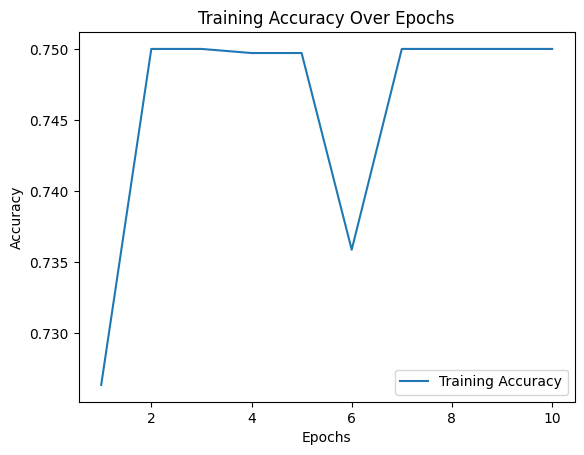

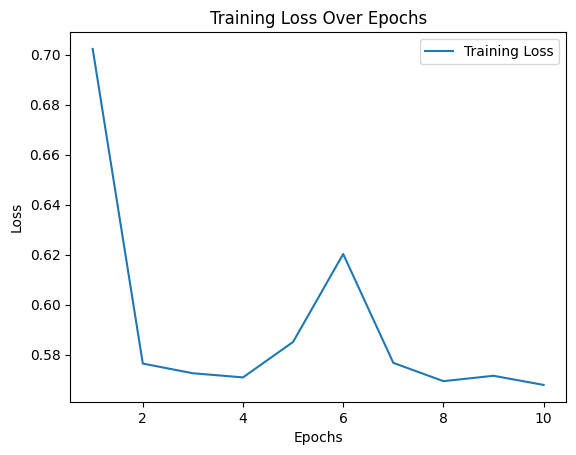

In [70]:
import matplotlib.pyplot as plt

# Train the model and obtain the 'history' variable

# Extract training metrics from the history
accuracy = history.history['accuracy']
loss = history.history['loss']

# Plot accuracy curve
plt.plot(range(1, len(accuracy) + 1), accuracy, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss curve
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [93]:
from sklearn.metrics import confusion_matrix, classification_report
#warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
# # Split your original dataset into training and validation sets
# train_data, validation_data = train_test_split(data, test_size=0.2, random_state=42)

validation_data = pd.read_csv("./datasets/Test_Dataset.csv")
validation_data['cleaned_tweet'] = validation_data['tweet'].apply(preprocess_text)

# Tokenize the validation set
validation_texts = validation_data['cleaned_tweet'].tolist()
validation_labels = validation_data['sarcastic'].astype(int).tolist()

tokenized_validation_inputs = tokenizer(validation_texts, return_tensors='tf', padding=True, truncation=True, max_length=128)
tf_tokenized_validation_inputs = {
    'input_ids': tf.constant(tokenized_validation_inputs['input_ids']),
    'attention_mask': tf.constant(tokenized_validation_inputs['attention_mask'])
}

# Predict on the validation set
validation_predictions = distilled_bert_model_with_attention.predict(tf_tokenized_validation_inputs)

# Ensure predicted labels have the correct shape and format
print("Shape of validation predictions:", validation_predictions.shape)

# Convert predictions to binary labels
predicted_labels = (validation_predictions[:, 0] > 0.5).astype(int)

# Check lengths of validation labels and predicted labels
print("Length of validation labels:", len(validation_labels))
print("Length of predicted labels:", len(predicted_labels))

# Create a confusion matrix
conf_matrix = confusion_matrix(validation_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Display classification report
print("\nClassification Report:")
print(classification_report(validation_labels, predicted_labels))

44/44 [==============================] - 76s 2s/step
Shape of validation predictions: (1400, 1)
Length of validation labels: 1400
Length of predicted labels: 1400
Confusion Matrix:
[[1200    0]
 [ 200    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1200
           1       0.00      0.00      0.00       200

    accuracy                           0.86      1400
   macro avg       0.43      0.50      0.46      1400
weighted avg       0.73      0.86      0.79      1400



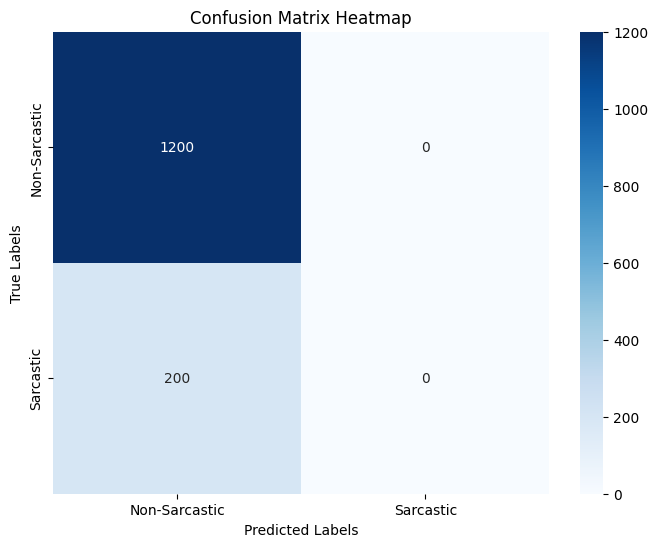

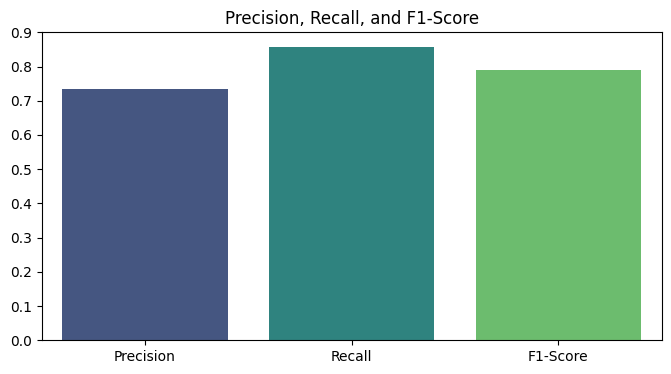

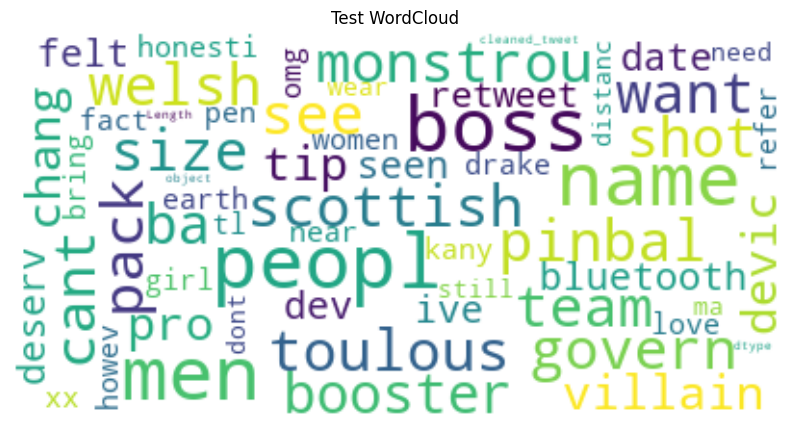

In [92]:
#graphs maps reports
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Sarcastic', 'Sarcastic'], yticklabels=['Non-Sarcastic', 'Sarcastic'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
#other matrices
# Plot precision, recall, and F1-score
classification_rep= classification_report(validation_labels, predicted_labels, output_dict=True)
precision = classification_rep['weighted avg']['precision']
recall = classification_rep['weighted avg']['recall']
f1_score = classification_rep['weighted avg']['f1-score']

metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1_score]

plt.figure(figsize=(8, 4))
sns.barplot(x=metrics, y=values, palette='viridis')
plt.title('Precision, Recall, and F1-Score')
plt.show()
#word cloud representation
import wordcloud as wordcloud
wordcloud = wordcloud.WordCloud(background_color="white", max_words=10000, max_font_size=40).generate(str(validation_data['cleaned_tweet']))
plt.figure(figsize=(10, 5))
plt.title("Test WordCloud")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



In [107]:
#sample testing based on user input
user_input = input("Enter your text")
#preprocess the input:
preprocessed_input = preprocess_text(user_input)
#tokenize the input
tokenized_inputs = tokenizer(preprocessed_input, return_tensors='tf', padding=True, truncation=True, max_length=128)
tf_tokenized_inputs = {
    'input_ids': tf.constant(tokenized_inputs['input_ids']),
    'attention_mask': tf.constant(tokenized_inputs['attention_mask'])
}
#predict with model
predictions = distilled_bert_model_with_attention.predict(tf_tokenized_inputs)
# Convert the prediction to a binary label
predicted_label = int(predictions[0] > 0.2)

# Display the prediction
if predicted_label == 1:
    print("The sentence is sarcastic.")
else:
    print("The sentence is not sarcastic.")
#The Sentence Given is "I love it when professors give question mark next to my answer."    

1/1 [==============================] - 0s 80ms/step
The sentence is sarcastic.
